In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
# twinLab import
import twinlab as tl
tl.set_user("cyd@digilab.co.uk")
tl.set_api_key("")

    solubility   diffusivity  p_out_grad
0     0.028020  8.760000e-09    0.477585
1     0.055181  5.180000e-09    0.554342
2     0.036963  7.560000e-09    0.541886
3     0.074160  2.810000e-09    0.405622
4     0.049637  4.150000e-09    0.401682
5     0.030888  4.700000e-09    0.284644
6     0.034798  2.260000e-09    0.154909
7     0.020558  6.070000e-09    0.244876
8     0.043949  9.930000e-09    0.839772
9     0.067970  7.040000e-09    0.918007
10    0.059851  8.470000e-09    0.971489
11    0.058152  1.990000e-09    0.227217
12    0.072146  9.300000e-09    1.277288
13    0.024091  1.520000e-09    0.072635
14    0.062474  3.830000e-09    0.465452
15    0.045923  1.080000e-10    0.009934
16    0.040886  3.350000e-09    0.268294
17    0.052570  6.680000e-09    0.678230
18    0.069814  6.050000e-10    0.083798
19    0.079865  5.640000e-09    0.865027


<>:3: DeprecationWarning: invalid escape sequence '\s'
<>:3: DeprecationWarning: invalid escape sequence '\s'
/var/folders/rq/1dyk93h5027fx7s4mn1lpdqm0000gn/T/ipykernel_81988/3521806241.py:3: DeprecationWarning: invalid escape sequence '\s'
  df = pd.read_csv("results.csv",sep="\s+")


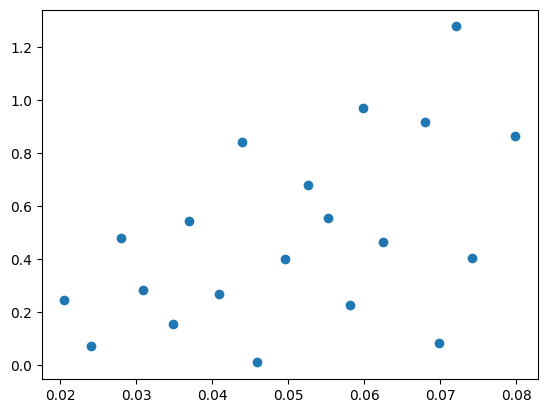

In [130]:
# read the training data from galaxy workflows

df = pd.read_csv("results.csv",sep="\s+")
print(df)
df_train = pd.DataFrame({
    "solubility": df["solubility"][:20],
    "logdiffusivity":np.log10(df["diffusivity"][:20]),
    "p_out_grad":df["p_out_grad"][:20]

})

plt.scatter(df_train["solubility"],df_train["p_out_grad"])

In [131]:
# Define the name of the dataset
dataset_id = "UoM_dataset"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df_train, verbose=True)

Dataframe is uploading.
Dataset successfully uploaded.


In [132]:
# Initialise emulator
emulator_id = "UoM_emulator"
emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
output_columns = ["p_out_grad"]
params = tl.TrainParams(
    train_test_ratio=1,
    estimator="gaussian_process_regression",

)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["logdiffusivity","solubility"],
    outputs=output_columns,
    params=params,
    verbose=True,
)

Emulator 'UoM_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: processing
0:00:08: Job status: success
Training of emulator UoM_emulator is complete!


In [133]:
npoints = 100

X, Y = np.meshgrid(np.linspace(np.min(df_train["logdiffusivity"]),np.max(df_train["logdiffusivity"]),npoints),
                    np.linspace(np.min(df_train["solubility"]),np.max(df_train["solubility"]),npoints))

df_test = pd.DataFrame({
    "logdiffusivity": X.flatten(),
    "solubility": Y.flatten(),
})

df_pred,df_std = emulator.predict(df_test)


Job predict process ID: predict-emerald-aquatic-carob
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:08: Job status: success
Mean predictions:
      p_out_grad
0       0.057079
1       0.054250
2       0.052089
3       0.050581
4       0.049705
...          ...
9995    1.238509
9996    1.285331
9997    1.331639
9998    1.377111
9999    1.421416

[10000 rows x 1 columns]
Standard deviation predictions:
      p_out_grad
0       0.141688
1       0.142805
2       0.145346
3       0.149152
4       0.154022
...          ...
9995    0.020953
9996    0.021903
9997    0.023153
9998    0.024791
9999    0.026908

[10000 rows x 1 columns]


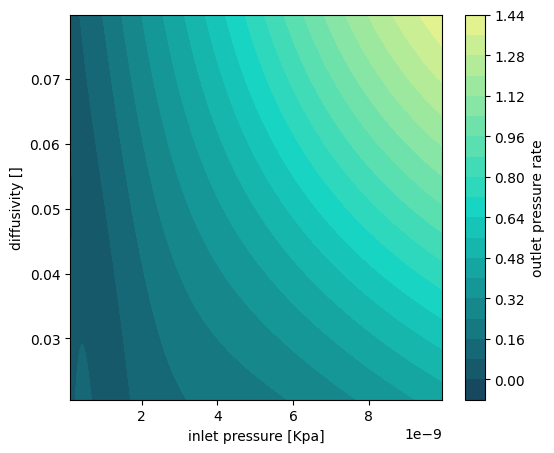

Text(0, 0.5, 'diffusivity []')

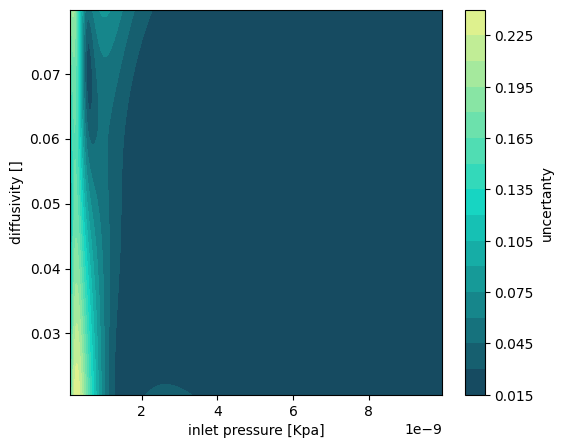

In [ ]:
# plot the outputs of the emulator
plt.figure(figsize=(6, 5))
colors = ["#16425B","#16D5C2","#EBF38B"]
custom_cmap = LinearSegmentedColormap.from_list("bah", colors) 

Z = np.array(df_pred["p_out_grad"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Z, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="permeation rate [pa/s]")
plt.xlabel("diffusivity")
plt.ylabel("solubility")
plt.show()

plt.figure(figsize=(6, 5))

Zerr = np.array(df_std["p_out_grad"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Zerr, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="uncertainty in permeation rate [pa/s]")
plt.xlabel("diffusivity")
plt.ylabel("solubility")